# Inefficient photon detection: Mixing stochastic and deterministic master equations

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from qutip import *

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.size'] = '14'

## Direct photo-detection

Here we follow an example from Wiseman and Milburn, *Quantum measurement and control*, section. 4.8.1.

Consider cavity that leaks photons with a rate $\kappa$. The dissipated photons are detected with an inefficient photon detector,
with photon-detection efficiency $\eta$. The master equation describing this scenario, where a separate dissipation channel has been added for detections and missed detections, is

$\dot\rho = -i[H, \rho] + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] + \mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a]$

To describe the photon measurement stochastically, we can unravelling only the dissipation term that corresponds to detections, and leaving the missed detections as a deterministic dissipation term, we obtain [Eq. (4.235) in W&M]

$d\rho = \mathcal{H}[-iH -\eta\frac{1}{2}a^\dagger a] \rho dt + \mathcal{D}[\sqrt{1-\eta} a] \rho dt + \mathcal{G}[\sqrt{\eta}a] \rho dN(t)$

or

$d\rho = -i[H, \rho] dt + \mathcal{D}[\sqrt{1-\eta} a] \rho dt -\mathcal{H}[\eta\frac{1}{2}a^\dagger a] \rho dt + \mathcal{G}[\sqrt{\eta}a] \rho dN(t)$

where

$\displaystyle \mathcal{G}[A] \rho = \frac{A\rho A^\dagger}{\mathrm{Tr}[A\rho A^\dagger]} - \rho$

$\displaystyle \mathcal{H}[A] \rho = A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho $

and $dN(t)$ is a Poisson distributed increment with $E[dN(t)] = \eta \langle a^\dagger a\rangle (t)$.

### Formulation in QuTiP

In QuTiP we write the stochastic master equation on the form:

$\displaystyle d\rho(t) = -i[H, \rho] dt + \mathcal{D}[B] \rho dt + D_{1}[A]\rho(t) dt + D_{2}[A]\rho(t) d\xi$

where the first two term gives the deterministic master equation (Lindblad form with collapse operator $B$). Here $A = \sqrt{\eta\gamma} a$ and $B = \sqrt{(1-\eta)\gamma} $a.

We can identify

$\displaystyle D_{1}[A]\rho(t) = - \frac{1}{2}\eta\gamma \mathcal{H}[a^\dagger a] \rho(t)
= - \frac{1}{2}\mathcal{H}[A^\dagger A] \rho(t)
= -\frac{1}{2}\left( A^\dagger A\rho + \rho A^\dagger A - \mathrm{Tr}[A^\dagger A\rho + \rho A^\dagger A] \rho \right)$

$\displaystyle D_{2}[A]\rho(t) = \mathcal{G}[\sqrt{\eta\gamma}a] \rho = \mathcal{G}[A] \rho = \frac{A\rho A^\dagger}{\mathrm{Tr}[A\rho A^\dagger]} - \rho$

and $d\xi = dN(t)$ with a Poisson distribution.

In [6]:
N = 15
w0 = 0.5 * 2 * np.pi
times = np.linspace(0, 15, 150)
dt = times[1] - times[0]
gamma = 0.1

In [7]:
a = destroy(N)

In [8]:
H = w0 * a.dag() * a

In [9]:
rho0 = fock(N, 5)

In [10]:
e_ops = [a.dag() * a, a + a.dag()]

### Define the stochastic terms

In [11]:
from qutip.expect import expect_rho_vec

In [12]:
# The argument A in the d1 and d2 callback functions is a list with the following
# precomputed superoperators, where c is the stochastic collapse operator given
# to the solver (called once for each operator, if more than one is given)
#
#     A[0] = spre(c)
#     A[1] = spost(c)
#     A[2] = spre(c.dag())
#     A[3] = spost(c.dag())
#     A[4] = spre(n)
#     A[5] = spost(n)
#     A[6] = (spre(c) * spost(c.dag())
#     A[7] = lindblad_dissipator(c)

$\displaystyle D_{1}[A]\rho(t) = -\frac{1}{2}\left( A^\dagger A\rho + \rho A^\dagger A - \mathrm{Tr}[A^\dagger A\rho + \rho A^\dagger A] \rho \right)$

In [13]:
def d1_rho_func(t, rho_vec, A, args):
    n_sum = A[4] + A[5]
    return 0.5 * (- n_sum * rho_vec + expect_rho_vec(n_sum, rho_vec, False) * rho_vec)

$\displaystyle D_{2}[A]\rho(t) = \frac{A\rho A^\dagger}{\mathrm{Tr}[A\rho A^\dagger]} - \rho$

In [14]:
def d2_rho_func(t, rho_vec, A, args):
    e1 = expect_rho_vec(A[6], rho_vec, False) + 1e-16  # add a small number to avoid division by zero
    return [(A[6] * rho_vec) / e1 - rho_vec]

### Highly efficient detection

In [15]:
eta = 0.7
c_ops = [np.sqrt(1-eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]   # stochastic collapse operator A

In [16]:
result_ref = mesolve(H, rho0, times, c_ops+sc_ops, e_ops)

In [17]:
result1 = smesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops, 
                   ntraj=1, nsubsteps=100, d1=d1_rho_func, d2=d2_rho_func,
                   distribution='poisson', store_measurement=True)

Total run time:   7.72s


In [18]:
result2 = smesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops, 
                  ntraj=10, nsubsteps=100, d1=d1_rho_func, d2=d2_rho_func,
                  distribution='poisson', store_measurement=True, map_func=parallel_map)

10.0%. Run time:   9.47s. Est. time left: 00:00:01:25
20.0%. Run time:   9.52s. Est. time left: 00:00:00:38
30.0%. Run time:  19.79s. Est. time left: 00:00:00:46
40.0%. Run time:  19.83s. Est. time left: 00:00:00:29
50.0%. Run time:  32.71s. Est. time left: 00:00:00:32
60.0%. Run time:  32.81s. Est. time left: 00:00:00:21
70.0%. Run time:  45.23s. Est. time left: 00:00:00:19
80.0%. Run time:  45.35s. Est. time left: 00:00:00:11
90.0%. Run time:  57.42s. Est. time left: 00:00:00:06
100.0%. Run time:  57.46s. Est. time left: 00:00:00:00
Total run time:  57.48s


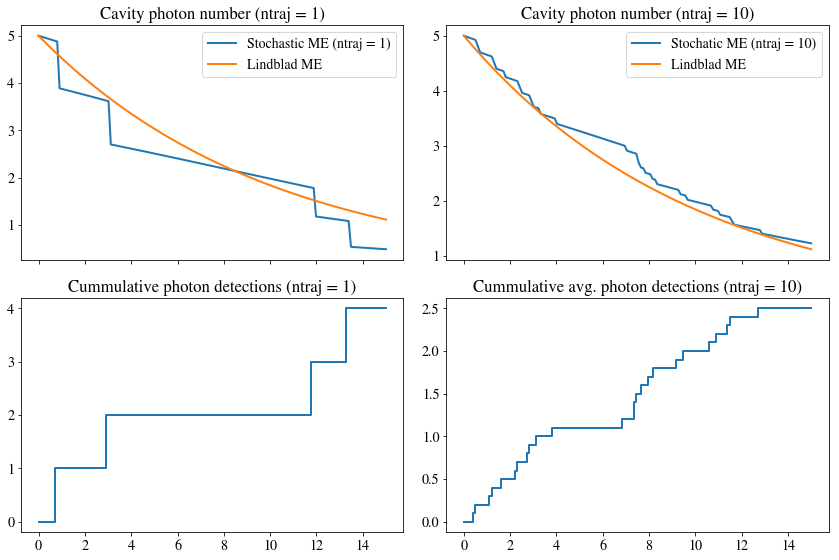

In [19]:
fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)

axes[0,0].plot(times, result1.expect[0], label=r'Stochastic ME (ntraj = 1)', lw=2)
axes[0,0].plot(times, result_ref.expect[0], label=r'Lindblad ME', lw=2)
axes[0,0].set_title("Cavity photon number (ntraj = 1)")
axes[0,0].legend()

axes[0,1].plot(times, result2.expect[0], label=r'Stochatic ME (ntraj = 10)', lw=2)
axes[0,1].plot(times, result_ref.expect[0], label=r'Lindblad ME', lw=2)
axes[0,1].set_title("Cavity photon number (ntraj = 10)")
axes[0,1].legend()

axes[1,0].step(times, dt * np.cumsum(result1.measurement[0].real), lw=2)
axes[1,0].set_title("Cummulative photon detections (ntraj = 1)")
axes[1,1].step(times, dt * np.cumsum(np.array(result2.measurement).sum(axis=0).real) / 10, lw=2)
axes[1,1].set_title("Cummulative avg. photon detections (ntraj = 10)")

fig.tight_layout()

### Highly inefficient photon detection

In [20]:
eta = 0.1
c_ops = [np.sqrt(1-eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]   # stochastic collapse operator A

In [21]:
result_ref = mesolve(H, rho0, times, c_ops+sc_ops, e_ops)

In [22]:
result1 = smesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops, 
                  ntraj=1, nsubsteps=100, d1=d1_rho_func, d2=d2_rho_func,
                  distribution='poisson', store_measurement=True)

Total run time:  14.24s


In [23]:
result2 = smesolve(H, rho0, times, c_ops=c_ops, sc_ops=sc_ops, e_ops=e_ops, 
                  ntraj=10, nsubsteps=100, d1=d1_rho_func, d2=d2_rho_func,
                  distribution='poisson', store_measurement=True, map_func=parallel_map)

10.0%. Run time:  12.02s. Est. time left: 00:00:01:48
20.0%. Run time:  12.08s. Est. time left: 00:00:00:48
30.0%. Run time:  24.19s. Est. time left: 00:00:00:56
40.0%. Run time:  24.38s. Est. time left: 00:00:00:36
50.0%. Run time:  35.22s. Est. time left: 00:00:00:35
60.0%. Run time:  35.57s. Est. time left: 00:00:00:23
70.0%. Run time:  46.71s. Est. time left: 00:00:00:20
80.0%. Run time:  47.09s. Est. time left: 00:00:00:11
90.0%. Run time:  57.88s. Est. time left: 00:00:00:06
100.0%. Run time:  58.76s. Est. time left: 00:00:00:00
Total run time:  58.79s


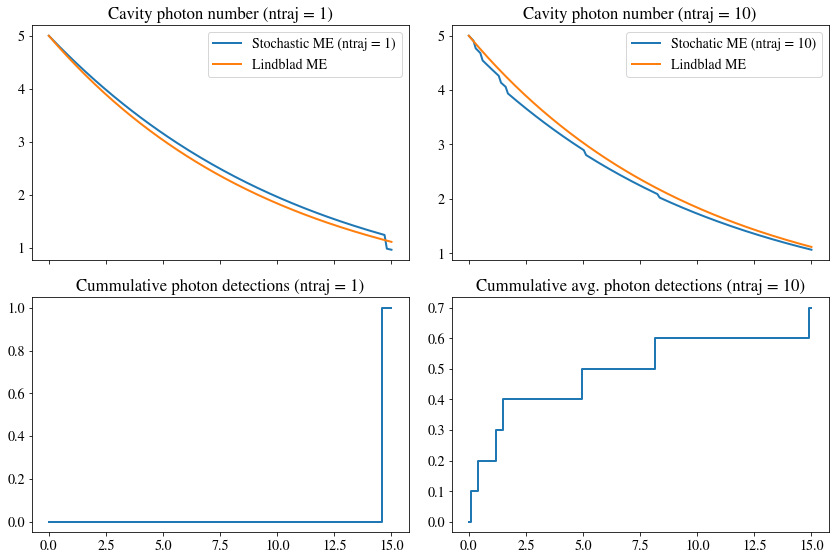

In [24]:
fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)

axes[0,0].plot(times, result1.expect[0], label=r'Stochastic ME (ntraj = 1)', lw=2)
axes[0,0].plot(times, result_ref.expect[0], label=r'Lindblad ME', lw=2)
axes[0,0].set_title("Cavity photon number (ntraj = 1)")
axes[0,0].legend()

axes[0,1].plot(times, result2.expect[0], label=r'Stochatic ME (ntraj = 10)', lw=2)
axes[0,1].plot(times, result_ref.expect[0], label=r'Lindblad ME', lw=2)
axes[0,1].set_title("Cavity photon number (ntraj = 10)")
axes[0,1].legend()

axes[1,0].step(times, dt * np.cumsum(result1.measurement[0].real), lw=2)
axes[1,0].set_title("Cummulative photon detections (ntraj = 1)")
axes[1,1].step(times, dt * np.cumsum(np.array(result2.measurement).sum(axis=0).real) / 10, lw=2)
axes[1,1].set_title("Cummulative avg. photon detections (ntraj = 10)")

fig.tight_layout()

## Efficient homodyne detection

The stochastic master equation for inefficient homodyne detection, when unravaling the detection part of the master equation

$\dot\rho = -i[H, \rho] + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] + \mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a]$,

is given in W&M as

$d\rho = -i[H, \rho]dt + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] \rho dt 
+
\mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a] \rho dt
+
\mathcal{H}[\sqrt{\eta} \sqrt{\kappa}a] \rho d\xi$

where $d\xi$ is the Wiener increment. This can be described as a standard homodyne detection with efficiency $\eta$ together with a stochastic dissipation process with collapse operator $\sqrt{(1-\eta)\kappa} a$. Alternatively we can combine the two deterministic terms on standard Lindblad for and obtain the stochastic equation (which is the form given in W&M)

$d\rho = -i[H, \rho]dt + \mathcal{D}[\sqrt{\kappa} a]\rho dt + \sqrt{\eta}\mathcal{H}[\sqrt{\kappa}a] \rho d\xi$

Below we solve these two equivalent equations with QuTiP

In [25]:
rho0 = coherent(N, np.sqrt(5))

### Form 1: Standard homodyne with deterministic dissipation on Lindblad form

In [26]:
eta = 0.95
c_ops = [np.sqrt(1-eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]   # stochastic collapse operator A

In [27]:
result_ref = mesolve(H, rho0, times, c_ops+sc_ops, e_ops)

In [28]:
result = smesolve(H, rho0, times, c_ops, sc_ops, e_ops, ntraj=125, nsubsteps=100,
                  method='homodyne', store_measurement=True, map_func=parallel_map)

10.4%. Run time:  62.47s. Est. time left: 00:00:08:58
20.0%. Run time: 114.58s. Est. time left: 00:00:07:38
30.4%. Run time: 178.91s. Est. time left: 00:00:06:49
40.0%. Run time: 241.52s. Est. time left: 00:00:06:02
50.4%. Run time: 301.92s. Est. time left: 00:00:04:57
60.0%. Run time: 354.87s. Est. time left: 00:00:03:56
70.4%. Run time: 409.16s. Est. time left: 00:00:02:52
80.0%. Run time: 456.10s. Est. time left: 00:00:01:54
90.4%. Run time: 514.94s. Est. time left: 00:00:00:54
100.0%. Run time: 551.89s. Est. time left: 00:00:00:00
Total run time: 551.96s


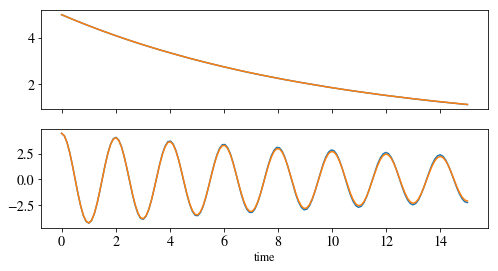

In [29]:
plot_expectation_values([result, result_ref]);

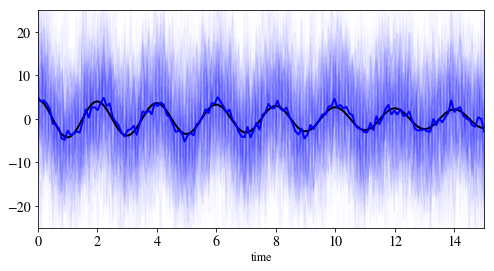

In [30]:
fig, ax = plt.subplots(figsize=(8,4))

M = np.sqrt(eta * gamma)

for m in result.measurement:
    ax.plot(times, m[:, 0].real / M, 'b', alpha=0.025)

ax.plot(times, result_ref.expect[1], 'k', lw=2);

ax.set_ylim(-25, 25)
ax.set_xlim(0, times.max())
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0].real / M, 'b', lw=2);

### Form 2: Combined homodyne with deterministic dissipation for missed detection events

$\displaystyle D_{1}[A]\rho(t) = \mathcal{D}[\kappa a]\rho(t) = \mathcal{D}[A]\rho(t)$

In [31]:
def d1_rho_func(t, rho_vec, A, args):
    return A[7] * rho_vec

$\displaystyle D_{2}[A]\rho(t) = \sqrt{\eta} \mathcal{H}[\sqrt{\kappa} a]\rho(t) = \sqrt{\eta} \mathcal{H}[A]\rho(t) 
= \sqrt{\eta}(A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho)
\rightarrow \sqrt{\eta} \left((A_L +  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L +  A_R^\dagger)\rho_v] \rho_v\right)$

In [32]:
def d2_rho_func(t, rho_vec, A, args):
    n_sum = A[0] + A[3]
    e1 = expect_rho_vec(n_sum, rho_vec, False)
    return [np.sqrt(eta) * (n_sum * rho_vec - e1 * rho_vec)]

In [33]:
c_ops = []
sc_ops = [np.sqrt(gamma) * a]

In [34]:
result_ref = mesolve(H, rho0, times, c_ops+sc_ops, e_ops)

In [35]:
result = smesolve(H, rho0, times, [], sc_ops, e_ops, 
                  ntraj=125, nsubsteps=100, d1=d1_rho_func, d2=d2_rho_func,
                  m_ops=[[a + a.dag()]], dW_factors=[1/np.sqrt(gamma * eta)],
                  distribution='normal', store_measurement=True, map_func=parallel_map)

10.4%. Run time:  70.82s. Est. time left: 00:00:10:10
20.0%. Run time: 146.80s. Est. time left: 00:00:09:47
30.4%. Run time: 206.99s. Est. time left: 00:00:07:53
40.0%. Run time: 252.40s. Est. time left: 00:00:06:18
50.4%. Run time: 295.15s. Est. time left: 00:00:04:50
60.0%. Run time: 317.35s. Est. time left: 00:00:03:31
70.4%. Run time: 346.93s. Est. time left: 00:00:02:25
80.0%. Run time: 373.24s. Est. time left: 00:00:01:33
90.4%. Run time: 400.29s. Est. time left: 00:00:00:42
100.0%. Run time: 430.12s. Est. time left: 00:00:00:00
Total run time: 430.15s


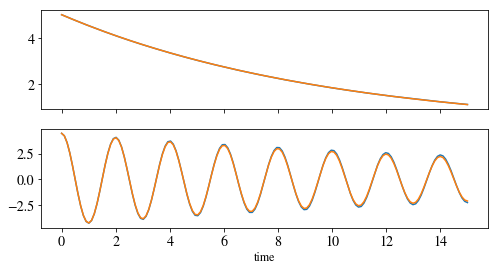

In [36]:
plot_expectation_values([result, result_ref]);

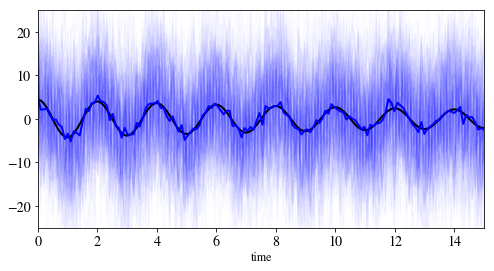

In [37]:
fig, ax = plt.subplots(figsize=(8,4))

for m in result.measurement:
    ax.plot(times, m[:, 0].real, 'b', alpha=0.025)

ax.plot(times, result_ref.expect[1], 'k', lw=2);

ax.set_ylim(-25, 25)
ax.set_xlim(0, times.max())
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0].real, 'b', lw=2);

## Versions

In [38]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.0.dev0+6e5b1d43
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
